# Using CReM in combination with machine learning models

This tutorial will exemplify the use of CReM in combination with machine learning models in optimization of a randomly chosen initial structure to a structure having high predicted end-point value. You may choose another starting molecule and look at the output.

In [23]:
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem, rdFingerprintGenerator
from rdkit.Chem import Draw, DataStructs
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG, Image
IPythonConsole.molSize = (400,300)
IPythonConsole.ipython_useSVG=True

from crem.crem import mutate_mol

import numpy as np
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
%matplotlib inline

RDLogger.DisableLog('rdApp.*') 
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)

In [24]:
# auxiliary functions to draw molecules with highlighting atoms 
def drawsvg(mol, highlightAtoms=[], highlightReplacement=False, molSize=(400, 300), kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        AllChem.Compute2DCoords(mc)
    if highlightReplacement:
        ids = []
        for a in mol.GetAtoms():
            if 'react_atom_idx' not in a.GetPropsAsDict():
                ids.append(a.GetIdx())
        if ids:
            highlightAtoms = ids
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0], molSize[1])
    drawer.DrawMolecule(mc, highlightAtoms=highlightAtoms)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return SVG(svg.replace('svg:',''))


def drawgrid(mols, highlight=0):
    """
    highlight: 0 - no highlight
               1 - highlight changed atoms
               2 - highlight unchanged atoms
    """
    if highlight == 0:
        return Draw.MolsToGridImage(mols[:8], molsPerRow=4, subImgSize=(300,200), useSVG=True)
    else:
        ids_list = []
        for m in mols:
            ids = []
            for a in m.GetAtoms():
                if 'react_atom_idx' not in a.GetPropsAsDict():
                    ids.append(a.GetIdx())
            if highlight == 1:
                ids_list.append(ids)
            elif highlight == 2:
                ids_list.append(list(set(range(m.GetNumAtoms())) - set(ids)))
        return Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(300,200), 
                                    highlightAtomLists=ids_list, useSVG=True)

In [25]:
def rdkit_numpy_convert(fp):
    # fp - list of binary fingerprints
    output = []
    for f in fp:
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(f, arr)
        output.append(arr)
    return np.asarray(output)

def get_top(ms, model):
    # ms - list of molecules
    # model - sklearn model
    fps1 = [mfpgen.GetFingerprint(m) for m in ms]
    x1 = rdkit_numpy_convert(fps1)
    pred = model.predict(x1)
    i = np.argmax(pred)
    return ms[i], round(pred[i], 3), pred.round(3)

def get_sim(ms, ref_fps):
    # ms - list of molecules
    # ref_fps - list of fingerprints of reference molecules
    output = []
    fps1 = [mfpgen.GetFingerprint(m) for m in ms]
    for fp in fps1:
        v = DataStructs.BulkTanimotoSimilarity(fp, ref_fps)
        i = np.argmax(v)
        output.append([v[i], i])
    return output

In this section we will:
- load structures of molecules with measured pKi values for histamine H1 receptor.
- create Random Forest model based on binary Morgan fingerprints

In [26]:
# read file with compounds  and their pKi value for 5-HT1a receptor
mols = []
names = []
y = []
with open('5ht1a.smi') as f:
    f.readline()  # skip header
    for line in f:
        smi, act = line.strip().split()
        m = Chem.MolFromSmiles(smi)
        if m:
            mols.append(m)
            # names.append(name)
            y.append(float(act))
len(mols)

3291

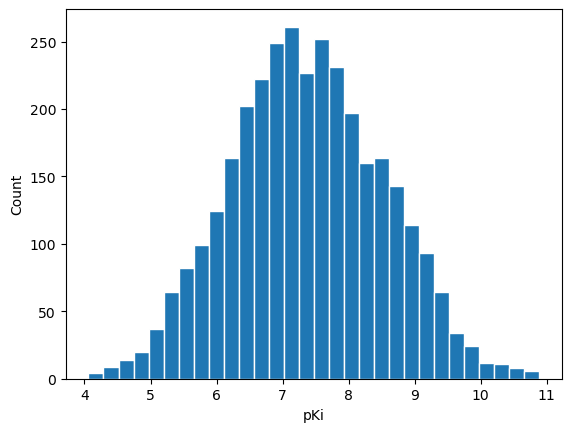

In [27]:
plt.hist(y, density=False, bins=30, edgecolor='white')  # density=False would make counts, otherwise density
plt.ylabel('Count')
plt.xlabel('pKi');

In [28]:
# create binary Morgan fingeprints and X matrix to train model
fps = [mfpgen.GetFingerprint(m) for m in mols]
x = rdkit_numpy_convert(fps)

In [29]:
# train Random forest model
# (here we do not optimize hyperparameters which is required for real use cases, this can be done with for example GridSearchCV)
m = RandomForestRegressor(n_estimators=100, n_jobs=4, random_state=42, oob_score=True)
m.fit(x, y)

RandomForestRegressor(n_jobs=4, oob_score=True, random_state=42)

In [30]:
# out-of-bag score can be considered as a measure of predictivy of a model
# (in real use cases cross-validation or external test set would be preferable)
m.oob_score_

0.7070568702393414

Let's implement a naive gready search algorithm. It will start from a given molecule. On each iteration the input molecule will be mutated using the corresponding CReM function. Activity of derived molecules will be estimated with the previosuly obtained model and the molecule with the highest score will be taken for the next iteration. The procedure will be reapeated until the improvement in the predicted end-point value will be observed.

In [31]:
# specify the path to the fragment database (replace with your actual path)
db_fname = 'chembl22_sa2_hac12.db'

In [32]:
# init a list collecting all molecules
all_new_mols = []

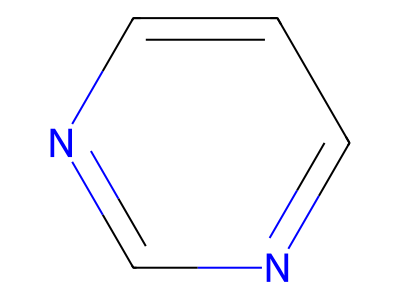

In [33]:
# let's start from pyridine or pyrimdine (comment unnecessary line)
mol = Chem.MolFromSmiles('c1ccncc1')  # pyridine
mol = Chem.MolFromSmiles('c1ncncc1')  # pyrimidine
mol

In [34]:
# estimate end-point value for aspirin
get_top([mol], m)[1]

5.739

molecules generated: 31
best score: 6.759


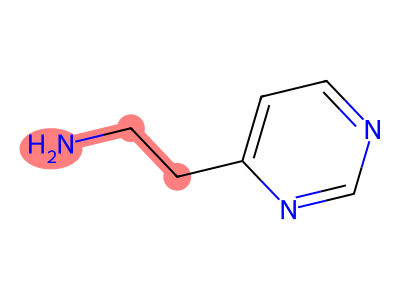

In [35]:
# iteration 1
new_mols = list(mutate_mol(Chem.AddHs(mol), db_name=db_fname, return_mol=True, min_size=0, max_size=8, min_inc=-3, max_inc=3, ncores=4))
new_mols = [Chem.RemoveHs(i[1]) for i in new_mols]
best_mol, score, all_scores = get_top(new_mols + [mol], m)
all_new_mols.extend(zip([Chem.MolToSmiles(m) for m in new_mols], all_scores))
print('molecules generated:', len(new_mols))
print('best score:', np.round(score, 3))
drawsvg(best_mol, highlightReplacement=True)

molecules generated: 453
best score: 7.322


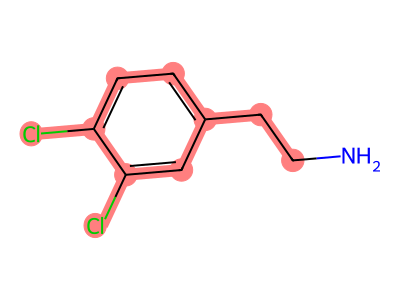

In [36]:
# iteration 2
mol = best_mol
new_mols = list(mutate_mol(Chem.AddHs(mol), db_name=db_fname, return_mol=True, min_size=0, max_size=8, min_inc=-3, max_inc=3, ncores=4))
new_mols = [Chem.RemoveHs(i[1]) for i in new_mols]
best_mol, score, all_scores = get_top(new_mols + [mol], m)
all_new_mols.extend(zip([Chem.MolToSmiles(m) for m in new_mols], all_scores))
print('molecules generated:', len(new_mols))
print('best score:', np.round(score, 3))
drawsvg(best_mol, highlightReplacement=True)

molecules generated: 428
best score: 7.626


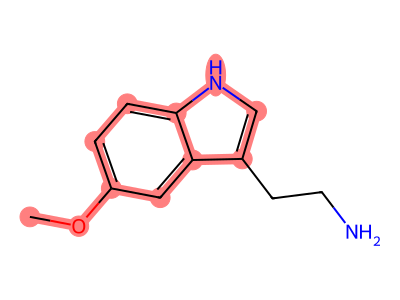

In [37]:
# iteration 3
mol = best_mol
new_mols = list(mutate_mol(Chem.AddHs(mol), db_name=db_fname, return_mol=True, min_size=0, max_size=8, min_inc=-3, max_inc=3, ncores=4))
new_mols = [Chem.RemoveHs(i[1]) for i in new_mols]
best_mol, score, all_scores = get_top(new_mols + [mol], m)
all_new_mols.extend(zip([Chem.MolToSmiles(m) for m in new_mols], all_scores))
print('molecules generated:', len(new_mols))
print('best score:', np.round(score, 3))
drawsvg(best_mol, highlightReplacement=True)

molecules generated: 169
best score: 8.612


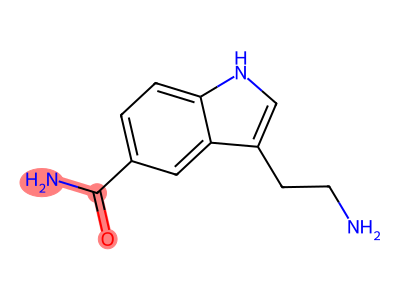

In [38]:
# iteration 4
mol = best_mol
new_mols = list(mutate_mol(Chem.AddHs(mol), db_name=db_fname, return_mol=True, min_size=0, max_size=8, min_inc=-3, max_inc=3, ncores=4))
new_mols = [Chem.RemoveHs(i[1]) for i in new_mols]
best_mol, score, all_scores = get_top(new_mols + [mol], m)
all_new_mols.extend(zip([Chem.MolToSmiles(m) for m in new_mols], all_scores))
print('molecules generated:', len(new_mols))
print('best score:', np.round(score, 3))
drawsvg(best_mol, highlightReplacement=True)

molecules generated: 207
best score: 8.612


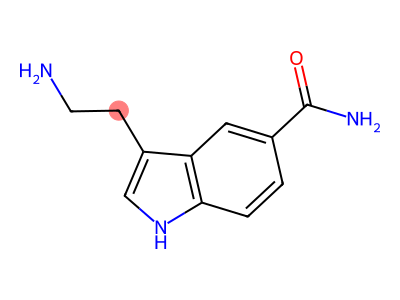

In [39]:
# iteration 5
mol = best_mol
new_mols = list(mutate_mol(Chem.AddHs(mol), db_name=db_fname, return_mol=True, min_size=0, max_size=8, min_inc=-3, max_inc=3, ncores=4))
new_mols = [Chem.RemoveHs(i[1]) for i in new_mols]
best_mol, score, all_scores = get_top(new_mols + [mol], m)
all_new_mols.extend(zip([Chem.MolToSmiles(m) for m in new_mols], all_scores))
print('molecules generated:', len(new_mols))
print('best score:', np.round(score, 3))
drawsvg(best_mol, highlightReplacement=True)

molecules generated: 207
best score: 8.612


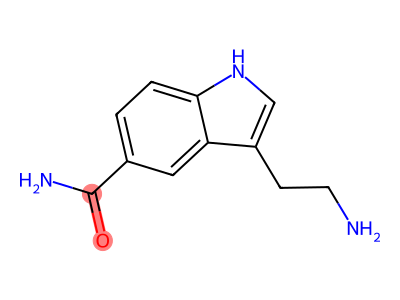

In [40]:
# iteration 6
mol = best_mol
new_mols = list(mutate_mol(Chem.AddHs(mol), db_name=db_fname, return_mol=True, min_size=0, max_size=8, min_inc=-3, max_inc=3, ncores=4))
new_mols = [Chem.RemoveHs(i[1]) for i in new_mols]
best_mol, score, all_scores = get_top(new_mols + [mol], m)
all_new_mols.extend(zip([Chem.MolToSmiles(m) for m in new_mols], all_scores))
print('molecules generated:', len(new_mols))
print('best score:', np.round(score, 3))
drawsvg(best_mol, highlightReplacement=True)

molecules generated: 207
best score: 8.612


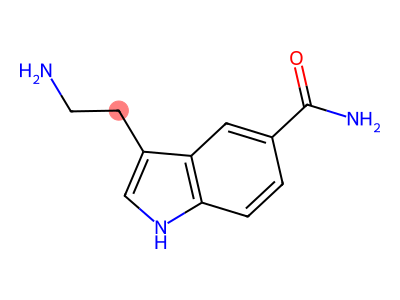

In [41]:
# iteration 7
mol = best_mol
new_mols = list(mutate_mol(Chem.AddHs(mol), db_name=db_fname, return_mol=True, min_size=0, max_size=8, min_inc=-3, max_inc=3, ncores=4))
new_mols = [Chem.RemoveHs(i[1]) for i in new_mols]
best_mol, score, all_scores = get_top(new_mols + [mol], m)
all_new_mols.extend(zip([Chem.MolToSmiles(m) for m in new_mols], all_scores))
print('molecules generated:', len(new_mols))
print('best score:', np.round(score, 3))
drawsvg(best_mol, highlightReplacement=True)

molecules generated: 207
best score: 8.612


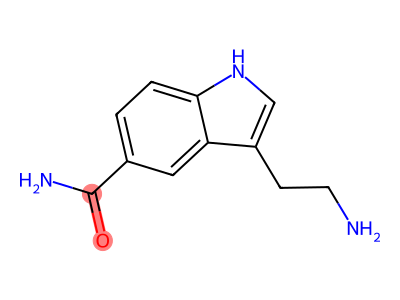

In [42]:
# iteration 8
mol = best_mol
new_mols = list(mutate_mol(Chem.AddHs(mol), db_name=db_fname, return_mol=True, min_size=0, max_size=8, min_inc=-3, max_inc=3, ncores=4))
new_mols = [Chem.RemoveHs(i[1]) for i in new_mols]
best_mol, score, all_scores = get_top(new_mols + [mol], m)
all_new_mols.extend(zip([Chem.MolToSmiles(m) for m in new_mols], all_scores))
print('molecules generated:', len(new_mols))
print('best score:', np.round(score, 3))
drawsvg(best_mol, highlightReplacement=True)

molecules generated: 207
best score: 8.612


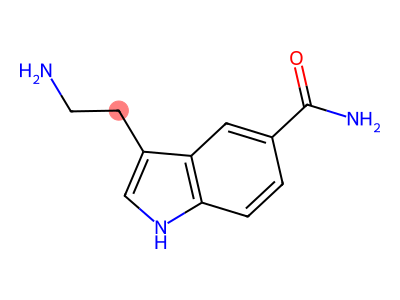

In [43]:
# iteration 9
mol = best_mol
new_mols = list(mutate_mol(Chem.AddHs(mol), db_name=db_fname, return_mol=True, min_size=0, max_size=8, min_inc=-3, max_inc=3, ncores=4))
new_mols = [Chem.RemoveHs(i[1]) for i in new_mols]
best_mol, score, all_scores = get_top(new_mols + [mol], m)
all_new_mols.extend(zip([Chem.MolToSmiles(m) for m in new_mols], all_scores))
print('molecules generated:', len(new_mols))
print('best score:', np.round(score, 3))
drawsvg(best_mol, highlightReplacement=True)

molecules generated: 207
best score: 8.612


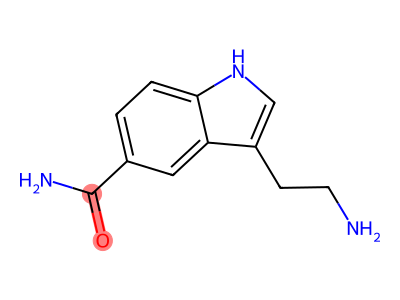

In [44]:
# iteration 10
mol = best_mol
new_mols = list(mutate_mol(Chem.AddHs(mol), db_name=db_fname, return_mol=True, min_size=0, max_size=8, min_inc=-3, max_inc=3, ncores=4))
new_mols = [Chem.RemoveHs(i[1]) for i in new_mols]
best_mol, score, all_scores = get_top(new_mols + [mol], m)
all_new_mols.extend(zip([Chem.MolToSmiles(m) for m in new_mols], all_scores))
print('molecules generated:', len(new_mols))
print('best score:', np.round(score, 3))
drawsvg(best_mol, highlightReplacement=True)

In [45]:
# calculate similarity of our best molecules to structures in the training dataset (we use Tanimoto on Morgan binary fingerprints)
sim, mol_id = get_sim([best_mol], fps)[0]
print(sim, mol_id)

1.0 2810


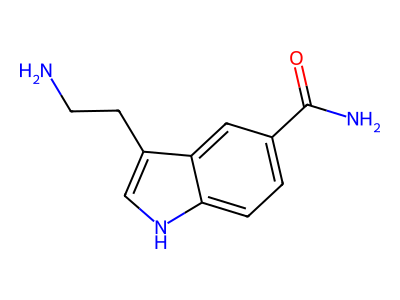

In [46]:
# this is the closest molecule from the training set
mols[mol_id]

In [47]:
y[mol_id]

9.585

In [50]:
with(open('crem-ml.txt', 'wt')) as f:
    for items in set(all_new_mols):
        f.write('\t'.join(map(str, items)) + '\n')